Gamma Ray Image Cleanig

1. Loading of data

In [4]:
data = np.loadtxt('gamma_0001_0050.txt')
print(data)

[[ 1.0000e+00  4.0000e+00  3.0000e+00 ...  4.0000e+00  5.0000e+00
   4.0000e+00]
 [ 1.0000e+00  5.0000e+00 -0.0000e+00 ...  3.0000e+00  3.0000e+00
   4.0000e+00]
 [ 1.0000e+00  9.0000e+00  4.0000e+00 ...  2.0000e+00  3.0000e+00
   2.0000e+00]
 ...
 [ 1.9998e+04  3.0000e+00  1.0000e+00 ...  3.0000e+00  4.0000e+00
   2.0000e+00]
 [ 1.9998e+04  4.0000e+00  1.0000e+00 ...  6.0000e+00  2.0000e+00
   8.0000e+00]
 [ 1.9998e+04  6.0000e+00  3.0000e+00 ...  5.0000e+00  1.0000e+00
   3.0000e+00]]


In [5]:
print(data.shape)

(2248704, 17)


In [6]:
def plot_single_event_histogram(pixels, amplitude, mean, std, bin_step=2, event_index=None):
    # Set custom bin step
    max_value = int(np.max(pixels)) + bin_step
    bins = np.arange(0, max_value + bin_step, bin_step)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 5))

    # Histogram
    count, bin_edges, _ = ax.hist(
        pixels.flatten(), bins=bins, alpha=0.7, color='skyblue', density=True, label='Pixel Histogram'
    )

    # Gaussian curve
    x_fit = np.linspace(0, max_value, 500)
    y_fit = amplitude * np.exp(-((x_fit - mean) ** 2) / (2 * std ** 2))

    ax.plot(x_fit, y_fit, 'r-', label='Fitted Gaussian')
    boundary_threshold = mean + 3 * std
    picture_threshold = mean + 5 * std

    # Plot vertical lines
    ax.axvline(boundary_threshold, color='orange', linestyle='--', linewidth=2, label='Boundary Threshold (μ + 3σ)')
    ax.axvline(picture_threshold, color='green', linestyle='--', linewidth=2, label='Picture Threshold (μ + 5σ)')

    ax.set_xlabel("Pixel Intensity")
    ax.set_ylabel("Density")
    title = f"Event {event_index} Histogram and Fitted Gaussian" if event_index is not None else "Histogram and Fitted Gaussian"
    ax.set_title(title)
    ax.legend()
    ax.grid(True)
    fig.tight_layout()
    plt.show()


In [7]:
event_numbers = data[:, 0]
pixel_data = data[:, 1:]
total_events = len(event_numbers)//16
print(total_events)

140544


In [8]:
event_data = pixel_data.reshape(total_events, 16, 16)
# Print the first event's 16x16 matrix
print("Event 0 pixel data (16x16 matrix):")
print(event_data[0])


Event 0 pixel data (16x16 matrix):
[[  4.   3.   0.   3.   2.   6.   5.   4.   3.   3.   4.   2.   8.   4.
    5.   4.]
 [  5.  -0.   3.   7.   3.   7.   7.   4.   3.   6.   0.   4.   4.   3.
    3.   4.]
 [  9.   4.   3.   6.   3.   1.   2.   4.   5.   2.   4.   3.   4.   2.
    3.   2.]
 [  8.   1.   3.   5.   3.   7.   2.   5.   7.   2.   4.   4.   2.   5.
    4.   7.]
 [  4.   6.   4.   3.   2.   1.   4.   4.   3.   2.   3.   4.   0.   9.
    3.   2.]
 [  5.   4.   5.   2.   3.  16.   4.   4.   4.   3.   5.   3.   8.   7.
    7.   5.]
 [  4.   4.   5.   3.   8.   8.   6.   9.   3.   4.   3.   5.   4.   7.
    4.   6.]
 [  0.   2.   3.   9.   8.   9.  17.  25.   9.   7.   4.   9.  16.   6.
    2.   2.]
 [  1.   2.   2.   5.  11.  19. 105. 289.  25.   9.   2.  18.   9.   5.
    7.   1.]
 [  4.   4.   2.   7.  10.  37.  81.  60.  11.   4.   7.   7.   6.   3.
    2.   6.]
 [  4.   2.   2.   9.   8.  11.  11.  15.   7.   4.   5.   5.   3.   6.
    2.   3.]
 [  1.   8.   4.   6.   9.   4

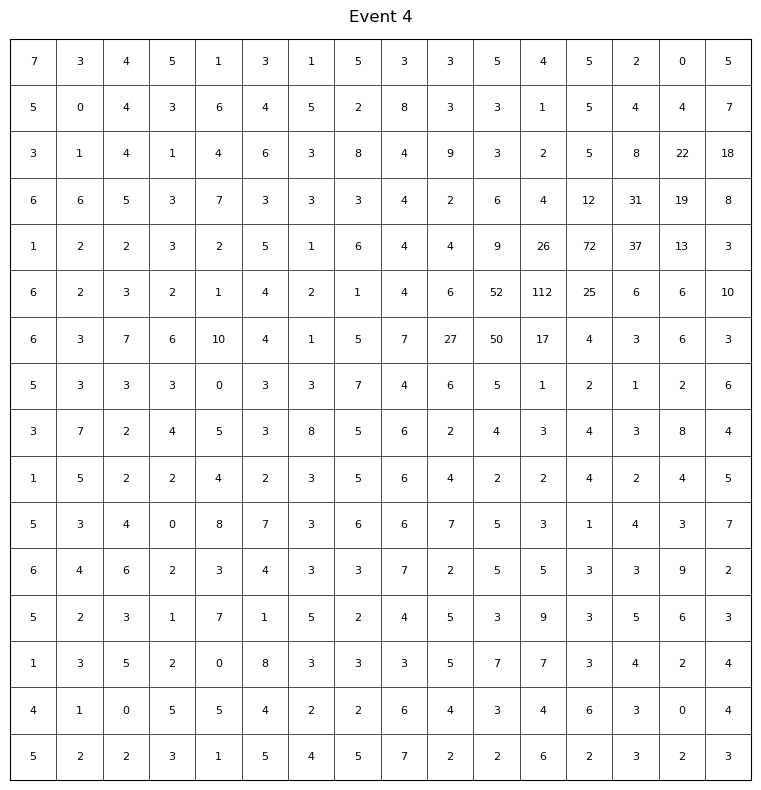

In [9]:
import matplotlib.pyplot as plt

# Use the first event
matrix = event_data[4]  # shape (16, 16)

#
# Plot the grid
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("Event 4", pad=12)

# Grid lines
ax.set_xticks(np.arange(16 + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(16 + 1) - 0.5, minor=True)
ax.grid(which="minor", color='black', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", bottom=False, left=False)
ax.set_xticks([])
ax.set_yticks([])

# Light background
ax.imshow(np.ones_like(matrix), cmap='gray_r')

# Add pixel values
for i in range(16):
    for j in range(16):
        ax.text(j, i, str(int(matrix[i, j])), ha='center', va='center', fontsize=8, color='black')



plt.tight_layout()
plt.show()


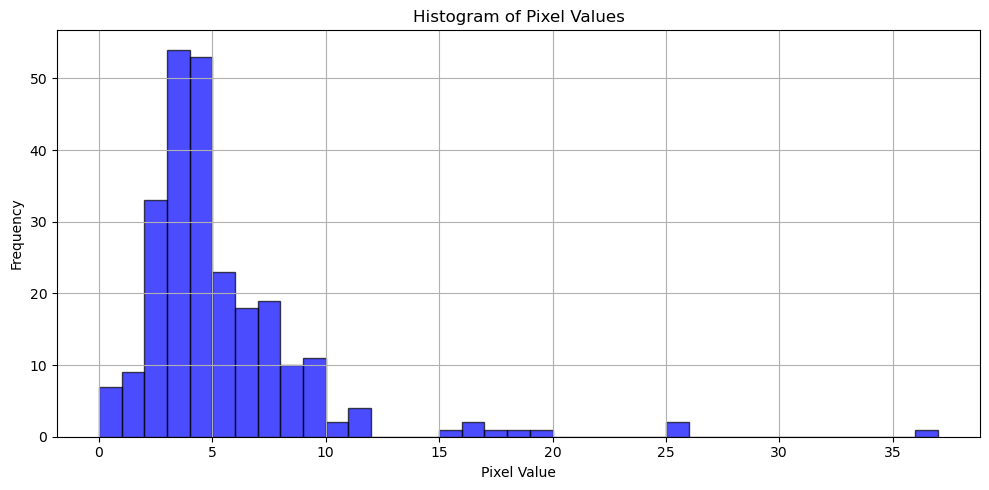

In [10]:
trial_matrix = event_data[0]  # shape (16, 16)
trial_values = trial_matrix.flatten()

filtered_values = trial_values[trial_values <= 50]
max_value = int(np.max(filtered_values))
# Set custom bin step, e.g., 2
bin_step = 1
bins = range(0, max_value + bin_step, bin_step)
plt.figure(figsize=(10, 5))
plt.hist(trial_values, bins=bins, alpha=0.7, color='blue', edgecolor='black')
plt.title("Histogram of Pixel Values")  
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

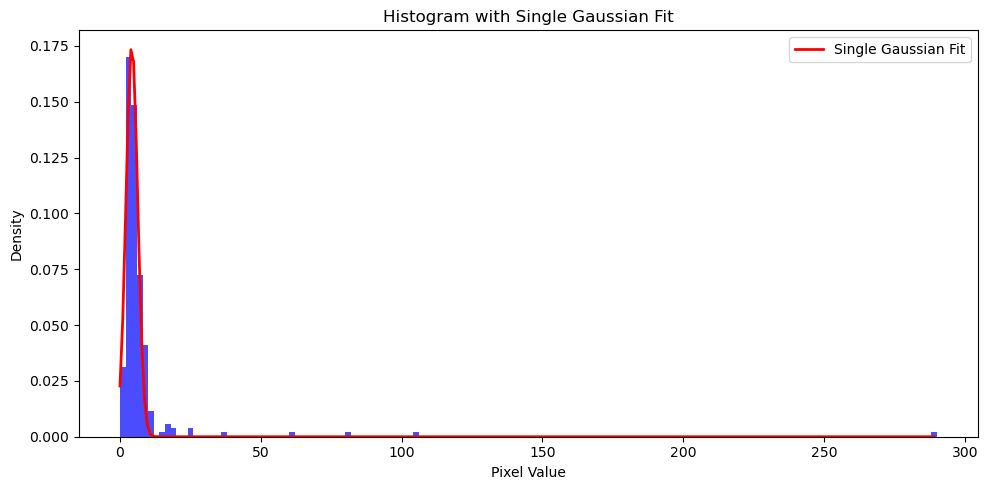

Fitted Mean: 4.21, Fitted Std: 2.08


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Example: Replace this with your actual data
# event_data = ...  # (your data array)
trial_matrix = event_data[0]  # shape (16, 16)
trial_values = trial_matrix.flatten()

# No filtering; use all values
max_value = int(np.max(trial_values))

# Set custom bin step
bin_step = 2
bins = np.arange(0, max_value + bin_step, bin_step)

plt.figure(figsize=(10, 5))

# Plot histogram
count, bin_edges, ignored = plt.hist(trial_values, bins=bins, alpha=0.7, color='blue', 
                                     density=True)

# Get bin centers for fitting
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Define single Gaussian function
def gaussian(x, amp, mu, sigma):
    return amp * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

# Initial guess: [amplitude, mean, std]
initial_guess = [0.2, np.mean(trial_values), np.std(trial_values)]

# Fit the Gaussian
popt, pcov = curve_fit(gaussian, bin_centers, count, p0=initial_guess)

# Plot the fitted curve
x_smooth = np.linspace(0, max_value, 300)
fitted_curve = gaussian(x_smooth, *popt)
plt.plot(x_smooth, fitted_curve, 'r-', linewidth=2, label='Single Gaussian Fit')

plt.title("Histogram with Single Gaussian Fit")
plt.xlabel("Pixel Value")
plt.ylabel("Density")
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Fitted Mean: {popt[1]:.2f}, Fitted Std: {popt[2]:.2f}")


In [12]:
amplitudes = np.zeros(total_events)
means = np.zeros(total_events)
std_devs = np.zeros(total_events)
bin_step = 2
for i in range(total_events):
    data = event_data[i].flatten()
    max_val = int(np.max(data))
    bins = np.arange(0, max_val +bin_step+ 1, bin_step)

    count, bin_edges = np.histogram(data, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    initial_guess = [np.max(count), np.mean(data), np.std(data)]
    
    
    popt, _ = curve_fit(gaussian, bin_centers, count, p0=initial_guess)
    amplitudes[i], means[i], std_devs[i] = popt
    


In [13]:
means_4d = means[:, np.newaxis, np.newaxis, np.newaxis]  # (100, 1, 1, 1)
std_devs_4d = std_devs[:, np.newaxis, np.newaxis, np.newaxis]
amplitudes_4d = amplitudes[:, np.newaxis, np.newaxis, np.newaxis]
pixels_expanded = event_data[:, :, :, np.newaxis]  # (total_events, 16, 16, 1)

means_broadcasted = np.broadcast_to(means_4d, (total_events, 16, 16, 1))
std_devs_broadcasted = np.broadcast_to(std_devs_4d, (total_events, 16, 16, 1))
amplitudes_broadcasted = np.broadcast_to(amplitudes_4d, (total_events, 16, 16, 1))

# Also expand the pixel data
pixels_expanded = event_data[:, :, :, np.newaxis]  # (total_events, 16, 16, 1)

# Now concatenate all → shape: (total_events, 16, 16, 4)
event_data_extended = np.concatenate([
    pixels_expanded,
    means_broadcasted,
    std_devs_broadcasted,
    amplitudes_broadcasted
], axis=-1)

print("Extended shape:", event_data_extended.shape)


Extended shape: (140544, 16, 16, 4)


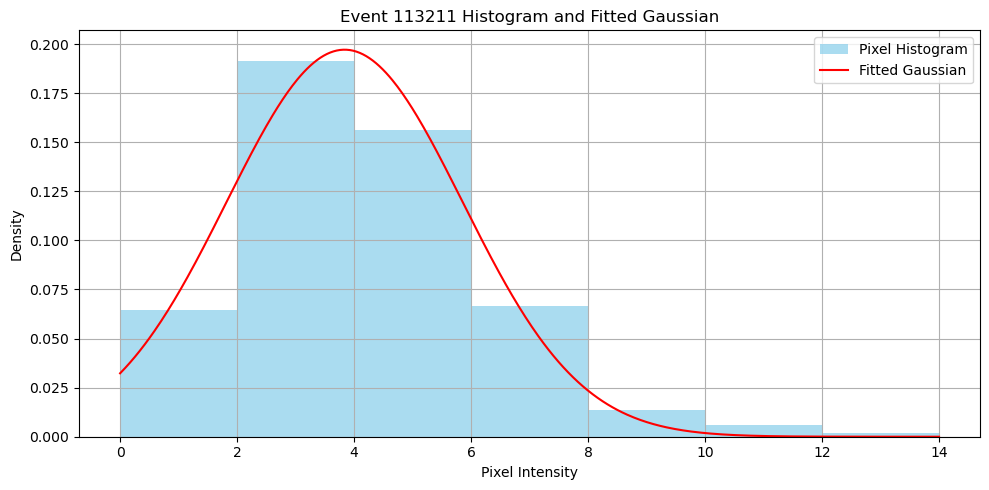

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Gaussian function definition
def gaussian(x, A, mu, sigma):
    return A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

# Pick a random event index
random_index = np.random.randint(total_events)

# Get the pixel values and flatten
trial_values = event_data[random_index].flatten()

# Get fitted Gaussian parameters
A = amplitudes[random_index]
mu = means[random_index]
sigma = std_devs[random_index]

# Set custom bin step
bin_step = 2
max_value = int(np.max(trial_values)) + bin_step
bins = np.arange(0, max_value + bin_step, bin_step)

# Plot
plt.figure(figsize=(10, 5))

# Histogram
count, bin_edges, _ = plt.hist(
    trial_values, bins=bins, alpha=0.7, color='skyblue', density=True, label='Pixel Histogram'
)

# Bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Gaussian curve
x_fit = np.linspace(0, max_value, 500)
y_fit = gaussian(x_fit, A, mu, sigma)

plt.plot(x_fit, y_fit, 'r-', label='Fitted Gaussian')
plt.xlabel("Pixel Intensity")
plt.ylabel("Density")
plt.title(f"Event {random_index} Histogram and Fitted Gaussian")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
boundary_threshold = means + 3 * std_devs
picture_threshold = means + 5 * std_devs

In [16]:
# `event_data_extended` shape: (140544, 16, 16, 4)

first_event = event_data_extended[0]  # shape: (16, 16, 4)

# Extract components:
pixels     = first_event[:, :, 0]  # 16x16 pixel values
mean       = first_event[0, 0, 1]  # same across all pixels
std_dev    = first_event[0, 0, 2]  # same across all pixels
amplitude  = first_event[0, 0, 3]  # same across all pixels

print("Pixel values:\n", pixels)
print("Mean:", mean)
print("Std Dev:", std_dev)
print("Amplitude:", amplitude)


Pixel values:
 [[  4.   3.   0.   3.   2.   6.   5.   4.   3.   3.   4.   2.   8.   4.
    5.   4.]
 [  5.  -0.   3.   7.   3.   7.   7.   4.   3.   6.   0.   4.   4.   3.
    3.   4.]
 [  9.   4.   3.   6.   3.   1.   2.   4.   5.   2.   4.   3.   4.   2.
    3.   2.]
 [  8.   1.   3.   5.   3.   7.   2.   5.   7.   2.   4.   4.   2.   5.
    4.   7.]
 [  4.   6.   4.   3.   2.   1.   4.   4.   3.   2.   3.   4.   0.   9.
    3.   2.]
 [  5.   4.   5.   2.   3.  16.   4.   4.   4.   3.   5.   3.   8.   7.
    7.   5.]
 [  4.   4.   5.   3.   8.   8.   6.   9.   3.   4.   3.   5.   4.   7.
    4.   6.]
 [  0.   2.   3.   9.   8.   9.  17.  25.   9.   7.   4.   9.  16.   6.
    2.   2.]
 [  1.   2.   2.   5.  11.  19. 105. 289.  25.   9.   2.  18.   9.   5.
    7.   1.]
 [  4.   4.   2.   7.  10.  37.  81.  60.  11.   4.   7.   7.   6.   3.
    2.   6.]
 [  4.   2.   2.   9.   8.  11.  11.  15.   7.   4.   5.   5.   3.   6.
    2.   3.]
 [  1.   8.   4.   6.   9.   4.   8.   5.   3.   3

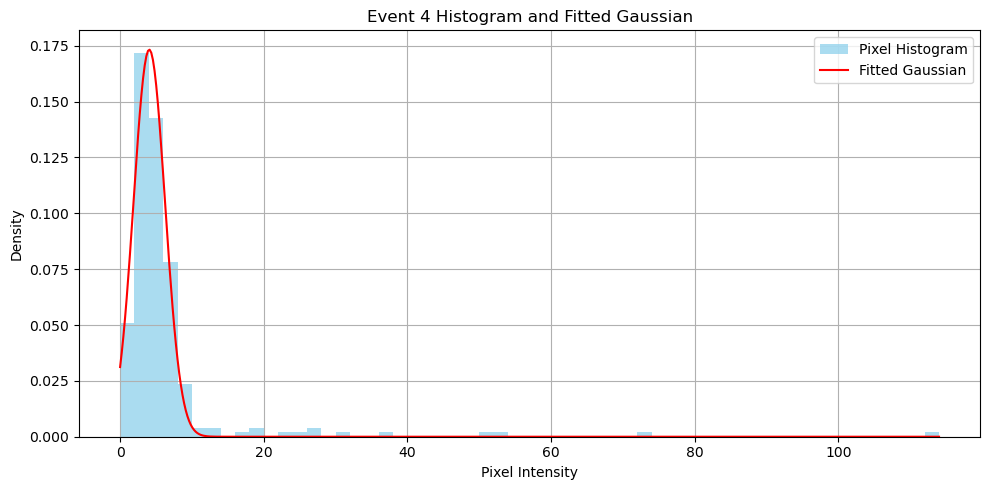

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Gaussian function definition
def gaussian(x, A, mu, sigma):
    return A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

# Select event 5
event_index = 4

# Get the pixel values and flatten
trial_values = event_data[event_index].flatten()

# Get fitted Gaussian parameters
A = amplitudes[event_index]
mu = means[event_index]
sigma = std_devs[event_index]

# Set custom bin step
bin_step = 2
max_value = int(np.max(trial_values)) + bin_step
bins = np.arange(0, max_value + bin_step, bin_step)

# Plot
plt.figure(figsize=(10, 5))

# Histogram
count, bin_edges, _ = plt.hist(
    trial_values, bins=bins, alpha=0.7, color='skyblue', density=True, label='Pixel Histogram'
)

# Bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Gaussian curve
x_fit = np.linspace(0, max_value, 500)
y_fit = gaussian(x_fit, A, mu, sigma)

plt.plot(x_fit, y_fit, 'r-', label='Fitted Gaussian')
plt.xlabel("Pixel Intensity")
plt.ylabel("Density")
plt.title(f"Event {event_index} Histogram and Fitted Gaussian")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


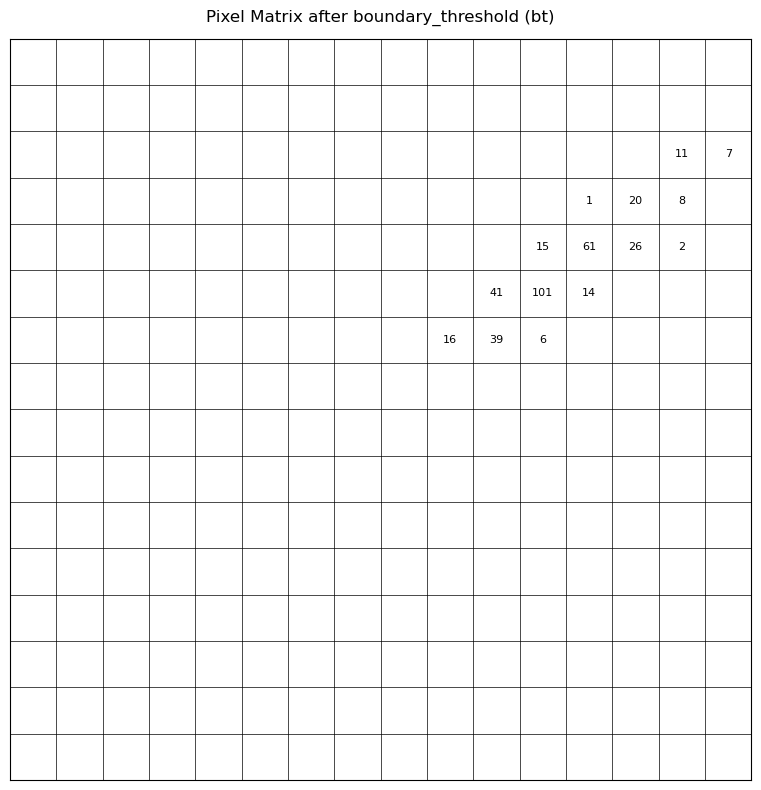

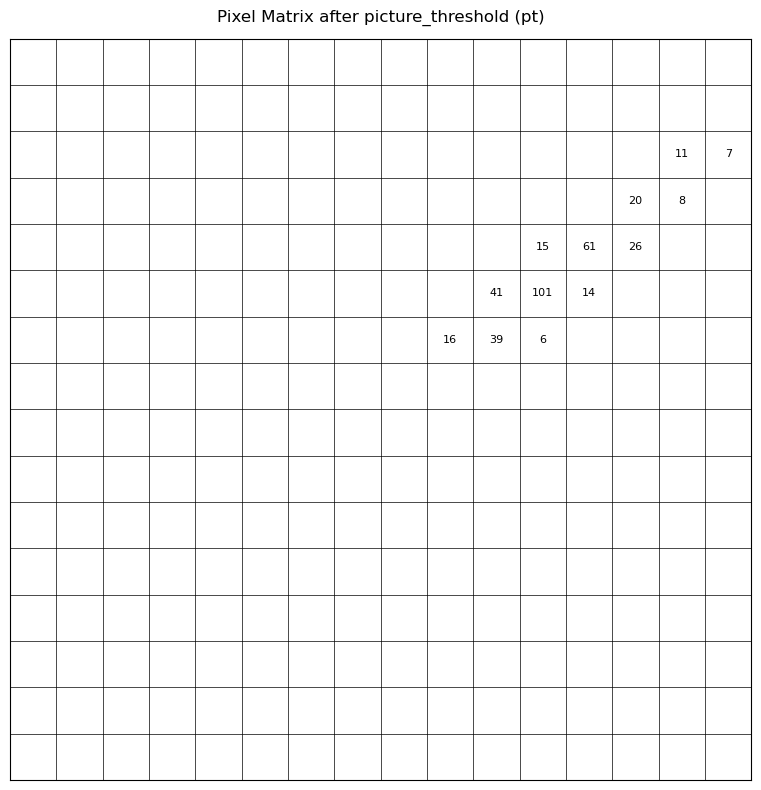

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Extract event 4 (shape: 16x16x4)
event = event_data_extended[4]

# Extract pixel values and stats
pixels = event[:, :, 0].copy()
mean   = event[0, 0, 1]
std    = event[0, 0, 2]

# Compute thresholds
bt = mean + 3 * std
pt = mean + 5 * std

# Helper to plot pixel matrix
def plot_pixel_matrix(matrix, title):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_title(title, pad=12)

    ax.set_xticks(np.arange(17) - 0.5, minor=True)
    ax.set_yticks(np.arange(17) - 0.5, minor=True)
    ax.grid(which="minor", color='black', linestyle='-', linewidth=0.5)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_xticks([])
    ax.set_yticks([])

    ax.imshow(np.ones_like(matrix), cmap='gray_r')

    for i in range(16):
        for j in range(16):
            if matrix[i, j] > 0:
                ax.text(j, i, str(int(matrix[i, j])), ha='center', va='center', fontsize=8, color='black')

    plt.tight_layout()
    plt.show()

# ---- Step 1: Zero pixels < bt ----
step1_pixels = pixels.copy()
step1_pixels -= bt
step1_pixels[step1_pixels < 0] = 0
plot_pixel_matrix(step1_pixels, "Pixel Matrix after boundary_threshold (bt)")

# ---- Step 2: Zero pixels < pt (already ≥ bt from Step 1) ----
step2_pixels = step1_pixels.copy()
step2_pixels[step2_pixels < (pt-bt)] = 0
plot_pixel_matrix(step2_pixels, "Pixel Matrix after picture_threshold (pt)")


In [19]:
print(mean, std, bt, pt)

4.059925579281646 2.1924487043075422 10.637271692204273 15.022169100819358


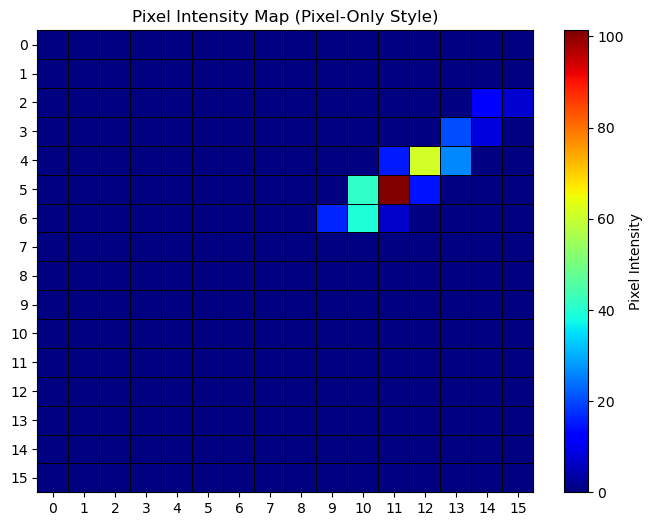

In [20]:
import numpy as np
import matplotlib.pyplot as plt



rows, cols = step2_pixels.shape
x = np.arange(cols + 1)
y = np.arange(rows + 1)

plt.figure(figsize=(8, 6))
plt.pcolormesh(x, y, step2_pixels, cmap='jet', edgecolors='black', linewidth=0.5)

# Add colorbar
cbar = plt.colorbar()
cbar.set_label("Pixel Intensity")

# Set ticks in center of each pixel
plt.xticks(np.arange(cols) + 0.5, np.arange(cols))
plt.yticks(np.arange(rows) + 0.5, np.arange(rows))
plt.gca().invert_yaxis()

plt.title("Pixel Intensity Map (Pixel-Only Style)")
plt.grid(False)
plt.show()


In [21]:
def extract_event_data(event_data_extended, event_number):
    event = event_data_extended[event_number]
    pixels = event[:, :, 0].copy()
    mean = event[0, 0, 1]
    std = event[0, 0, 2]
    amplitude = event[0, 0, 3]
    return pixels, mean, std, amplitude



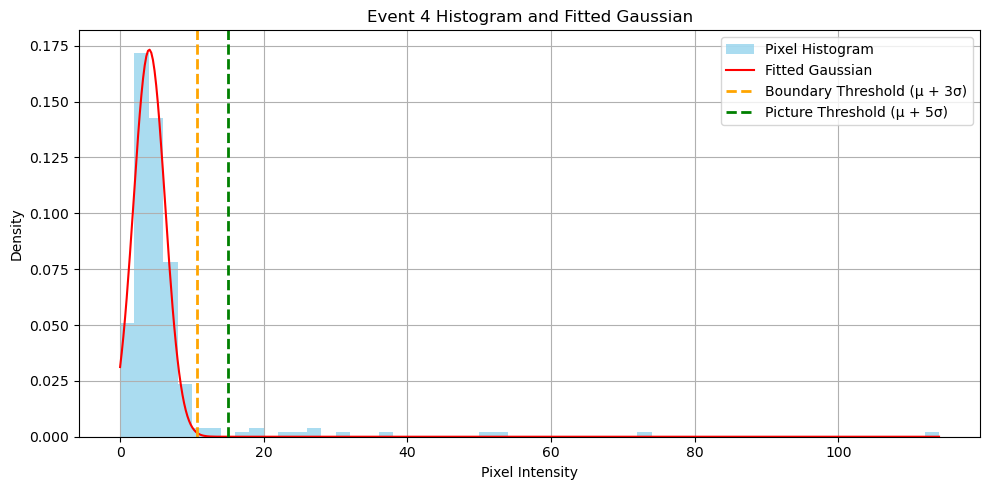

In [22]:
# Example usage
pixels, mean, std, amplitude = extract_event_data(event_data_extended, 4)
plot_single_event_histogram(pixels, amplitude, mean, std, event_index=4)

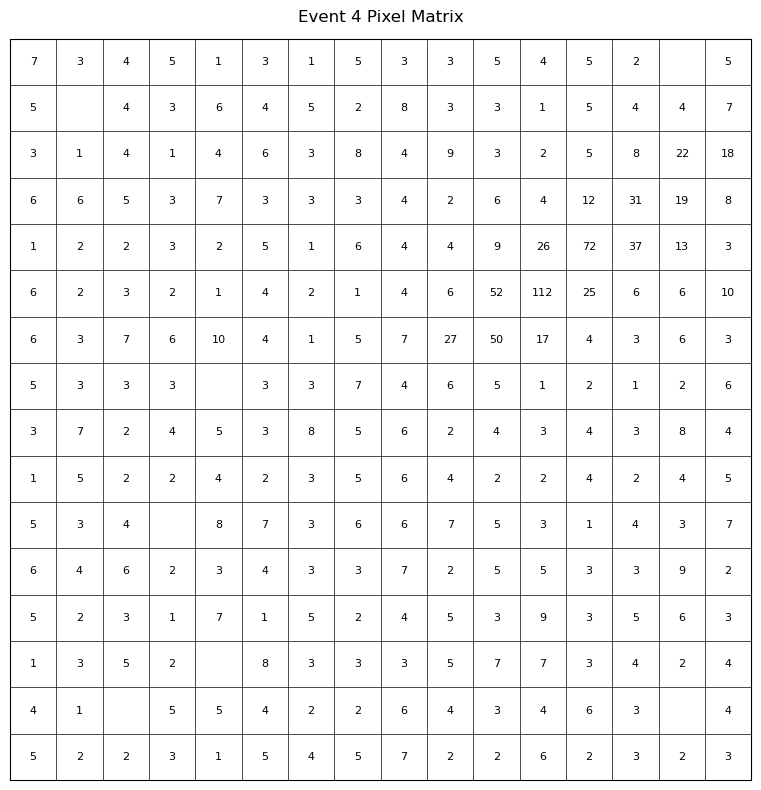

In [23]:
plot_pixel_matrix(pixels, "Event 4 Pixel Matrix")

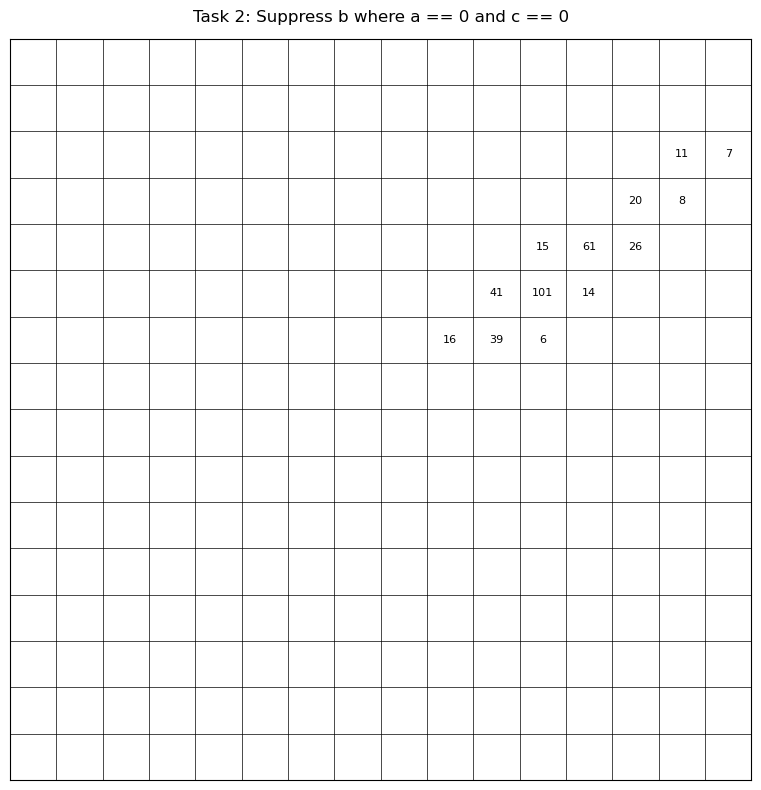

In [24]:
task2_pixels = step2_pixels.copy()
for i in range(16):
    for j in range(1, 15):  # skip edges to avoid index error
        a = task2_pixels[i, j - 1]
        b = task2_pixels[i, j]
        c = task2_pixels[i, j + 1]
        if a == 0 and c == 0:
            task2_pixels[i, j] = 0

plot_pixel_matrix(task2_pixels, "Task 2: Suppress b where a == 0 and c == 0")


In [25]:
def plot_pixel_matrix_with_cg(matrix, title):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_title(title, pad=12)

    ax.set_xticks(np.arange(17) - 0.5, minor=True)
    ax.set_yticks(np.arange(17) - 0.5, minor=True)
    ax.grid(which="minor", color='black', linestyle='-', linewidth=0.5)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_xticks([])
    ax.set_yticks([])

    ax.imshow(np.ones_like(matrix), cmap='gray_r')

    # Text values
    for i in range(16):
        for j in range(16):
            if matrix[i, j] > 0:
                ax.text(j, i, str(int(matrix[i, j])), ha='center', va='center', fontsize=8, color='black')

    # Compute Center of Gravity (CG)
    Y, X = np.indices(matrix.shape)
    total_intensity = np.sum(matrix)
    x_cg = np.sum(X * matrix) / total_intensity
    y_cg = np.sum(Y * matrix) / total_intensity

    # Plot CG as a red dot
    ax.plot(x_cg, y_cg, 'ro', markersize=6, label='CG')

    ax.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

    print(f"Center of Gravity (x_cg, y_cg): ({x_cg:.2f}, {y_cg:.2f})")


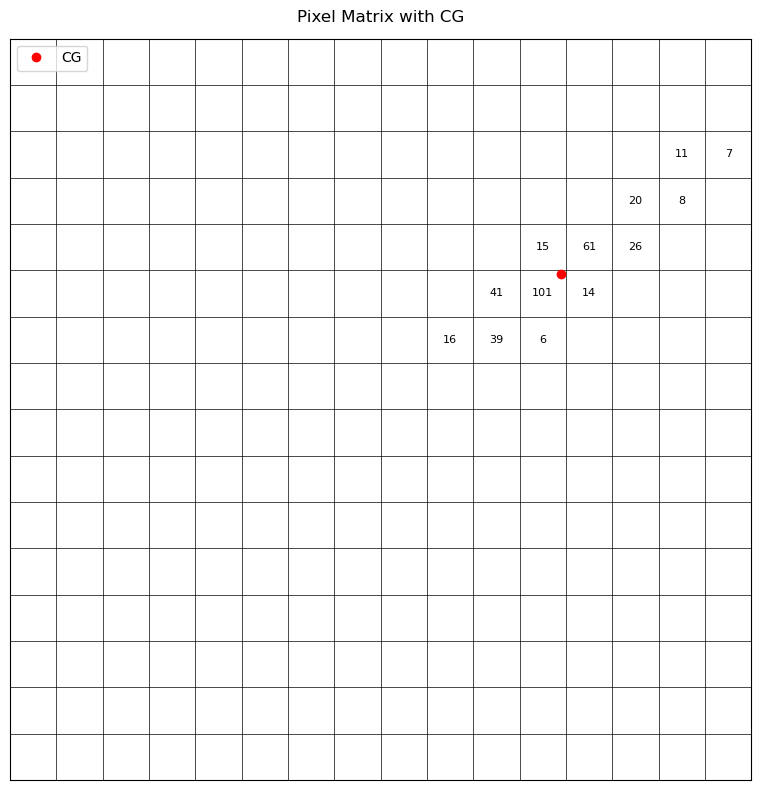

Center of Gravity (x_cg, y_cg): (11.39, 4.58)


In [26]:
# Assuming 'step2_pixels' is a 16x16 NumPy array
plot_pixel_matrix_with_cg(step2_pixels, "Pixel Matrix with CG")


In [27]:
def convert_to_metadata_format(event_data_extended):
    N = event_data_extended.shape[0]  # number of events

    # Pixel data: shape (N, 16, 16)
    pixel_data = event_data_extended[:, :, :, 0]

    # Metadata: mean, std, amplitude → shape (N, 3)
    metadata = event_data_extended[:, 0, 0, 1:4]

    return pixel_data, metadata
# metadata is a NumPy array of shape (N, 3), where each row corresponds to one event.
# For each event:
#   metadata[i, 0] → mean value of the event
#   metadata[i, 1] → standard deviation (std) of the event
#   metadata[i, 2] → amplitude of the event

In [28]:
pixel_data, metadata = convert_to_metadata_format(event_data_extended)
print("Pixel Data Shape:", pixel_data.shape)  # Should be (N, 16, 16)
print("Metadata Shape:", metadata.shape)  # Should be (N, 3)
# Example: Print metadata for the first event
print("Metadata for Event 0:", metadata[0])  # Should print mean, std, amplitude for event 0

Pixel Data Shape: (140544, 16, 16)
Metadata Shape: (140544, 3)
Metadata for Event 0: [4.20642467 2.07903287 0.17568037]


In [29]:
from typing import Tuple
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt

@dataclass
class ShowerAnalysisResult:
    centroid_position: Tuple[float, float]
    longitudinal_extension: float
    transverse_extension: float
    orientation_angle_degrees: float
    elliptical_eccentricity: float
    edge_leakage_ratio: float
    axis_miss_distance: float
    azimuthal_spread: float
    distribution_asymmetry: float
    radial_displacement: float
    radial_orientation_angle: float

def analyze_shower(
    photon_electron_matrix: np.ndarray,
    x_positions: np.ndarray = None,
    y_positions: np.ndarray = None,
    generate_visualization: bool = True
) -> ShowerAnalysisResult:
    
    # Center coordinates at sensor origin
    if x_positions is None:
        sensor_center_x = (photon_electron_matrix.shape[1] - 1) / 2
        x_positions = np.arange(photon_electron_matrix.shape[1]) - sensor_center_x
    if y_positions is None:
        sensor_center_y = (photon_electron_matrix.shape[0] - 1) / 2
        y_positions = np.arange(photon_electron_matrix.shape[0]) - sensor_center_y

    total_photon_electrons = np.sum(photon_electron_matrix)
    if total_photon_electrons == 0:
        raise ValueError("Photon-electron matrix contains no detectable signal")

    # Calculate edge leakage
    left_edge_sum = np.sum(photon_electron_matrix[:, 0])
    right_edge_sum = np.sum(photon_electron_matrix[:, -1])
    top_edge_sum = np.sum(photon_electron_matrix[0, :])
    bottom_edge_sum = np.sum(photon_electron_matrix[-1, :])
    total_edge_leakage = left_edge_sum + right_edge_sum + top_edge_sum + bottom_edge_sum
    edge_leakage_ratio = total_edge_leakage / total_photon_electrons

    # Create coordinate grids
    x_grid, y_grid = np.meshgrid(x_positions, y_positions, indexing='xy')

    # Calculate centroid position
    centroid_x = np.sum(photon_electron_matrix * x_grid) / total_photon_electrons
    centroid_y = np.sum(photon_electron_matrix * y_grid) / total_photon_electrons

    # Compute second moments
    second_moment_xx = np.sum(photon_electron_matrix * x_grid**2) / total_photon_electrons - centroid_x**2
    second_moment_yy = np.sum(photon_electron_matrix * y_grid**2) / total_photon_electrons - centroid_y**2
    cross_moment_xy = np.sum(photon_electron_matrix * x_grid * y_grid) / total_photon_electrons - centroid_x * centroid_y

    moment_difference = second_moment_yy - second_moment_xx
    orientation_angle_radians = 0.5 * np.arctan2(2 * cross_moment_xy, moment_difference)
    orientation_angle_degrees = np.degrees(orientation_angle_radians)
    if orientation_angle_degrees < 0:
        orientation_angle_degrees += 180

    # Calculate principal axes
    moment_combination = np.sqrt(moment_difference**2 + 4 * cross_moment_xy**2)
    longitudinal_extension = np.sqrt((second_moment_xx + second_moment_yy + moment_combination) / 2)
    transverse_extension = np.sqrt(abs((second_moment_xx + second_moment_yy - moment_combination) / 2))

    # Compute elliptical eccentricity
    elliptical_eccentricity = np.sqrt(1 - (transverse_extension / longitudinal_extension)**2) if longitudinal_extension != 0 else 0

    # Calculate miss distance from origin to major axis
    if cross_moment_xy != 0:
        major_axis_slope = (moment_difference + moment_combination) / (2 * cross_moment_xy)
        axis_intercept = centroid_y - major_axis_slope * centroid_x
        axis_miss_distance = abs(axis_intercept) / np.sqrt(1 + major_axis_slope**2)
    else:
        axis_miss_distance = abs(centroid_y)

    # Calculate radial displacement and direction
    radial_displacement = np.sqrt(centroid_x**2 + centroid_y**2)
    radial_angle_degrees = np.degrees(np.arctan2(centroid_y, centroid_x))
    if radial_angle_degrees < 0:
        radial_angle_degrees += 180

    # Compute angular difference between radial vector and shower axis
    if centroid_x == 0:
        radial_slope = 999.0
    else:
        radial_slope = centroid_y / centroid_x
    axis_slope = np.tan(orientation_angle_radians)
    slope_denominator = 1 + axis_slope * radial_slope
    if slope_denominator == 0:
        radial_orientation_angle = 90.0
    else:
        radial_orientation_angle = np.degrees(np.arctan(abs((axis_slope - radial_slope) / slope_denominator)))

    # Calculate azimuthal spread
    azimuthal_spread = np.sqrt(
        (longitudinal_extension * np.sin(np.radians(radial_orientation_angle)))**2 +
        (transverse_extension * np.cos(np.radians(radial_orientation_angle)))**2
    )

    # Compute distribution asymmetry
    third_moment_x = np.sum(photon_electron_matrix * (x_grid - centroid_x)**3)
    third_moment_y = np.sum(photon_electron_matrix * (y_grid - centroid_y)**3)
    raw_asymmetry = (third_moment_x + third_moment_y) / total_photon_electrons
    distribution_asymmetry = abs(raw_asymmetry)**(1/3) / longitudinal_extension if longitudinal_extension != 0 else 0

    if generate_visualization:
        plt.figure(figsize=(10, 8))

        # Create edge coordinates for proper alignment
        x_edges = np.linspace(x_positions[0]-0.5, x_positions[-1]+0.5, photon_electron_matrix.shape[1]+1)
        y_edges = np.linspace(y_positions[0]-0.5, y_positions[-1]+0.5, photon_electron_matrix.shape[0]+1)
        mesh_plot = plt.pcolormesh(x_edges, y_edges, photon_electron_matrix, 
                                 cmap='viridis', edgecolors='black', linewidth=0.5)

        # Create fitted ellipse
        ellipse_major_axis = 1.4 * longitudinal_extension
        ellipse_minor_axis = 1.4 * transverse_extension
        angle_parameterization = np.linspace(0, 2 * np.pi, 200)
        ellipse_x_coordinates = (
            centroid_x + 
            ellipse_major_axis * np.cos(angle_parameterization) * np.cos(orientation_angle_radians) - 
            ellipse_minor_axis * np.sin(angle_parameterization) * np.sin(orientation_angle_radians)
        )
        ellipse_y_coordinates = (
            centroid_y + 
            ellipse_major_axis * np.cos(angle_parameterization) * np.sin(orientation_angle_radians) + 
            ellipse_minor_axis * np.sin(angle_parameterization) * np.cos(orientation_angle_radians)
        )
        plt.plot(ellipse_x_coordinates, ellipse_y_coordinates, 'w-', linewidth=2, label='Fitted Ellipse')

        # Plot centroid and origin connection
        plt.scatter([centroid_x], [centroid_y], color='magenta', edgecolors='black', 
                  label='Energy Centroid', zorder=3)
        plt.plot([0, centroid_x], [0, centroid_y], 'cyan', linestyle='--', 
               linewidth=1.5, label='Center-to-Centroid Vector')

        # Configure axes and labels
        plt.xticks(x_positions, rotation=45)
        plt.yticks(y_positions)
        plt.gca().invert_yaxis()
        plt.grid(visible=False)
        color_bar = plt.colorbar(mesh_plot)
        color_bar.set_label("Photon-Electron Count")
        plt.title("Particle Shower Profile with Elliptical Approximation", pad=20)
        plt.xlabel("X Position (Sensor Units)")
        plt.ylabel("Y Position (Sensor Units)")
        plt.legend(loc='upper right', framealpha=0.9)
        plt.tight_layout()
        plt.show()

    return ShowerAnalysisResult(
        centroid_position=(centroid_x, centroid_y),
        longitudinal_extension=longitudinal_extension,
        transverse_extension=transverse_extension,
        orientation_angle_degrees=orientation_angle_degrees,
        elliptical_eccentricity=elliptical_eccentricity,
        edge_leakage_ratio=edge_leakage_ratio,
        axis_miss_distance=axis_miss_distance,
        azimuthal_spread=azimuthal_spread,
        distribution_asymmetry=distribution_asymmetry,
        radial_displacement=radial_displacement,
        radial_orientation_angle=radial_orientation_angle
    )


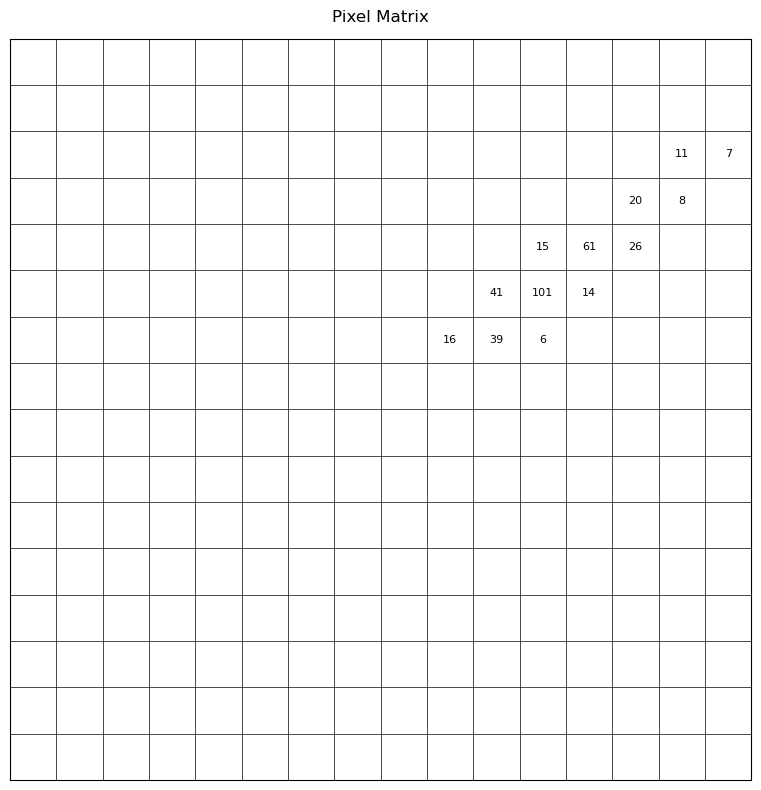

In [30]:
plot_pixel_matrix(step2_pixels, "Pixel Matrix")

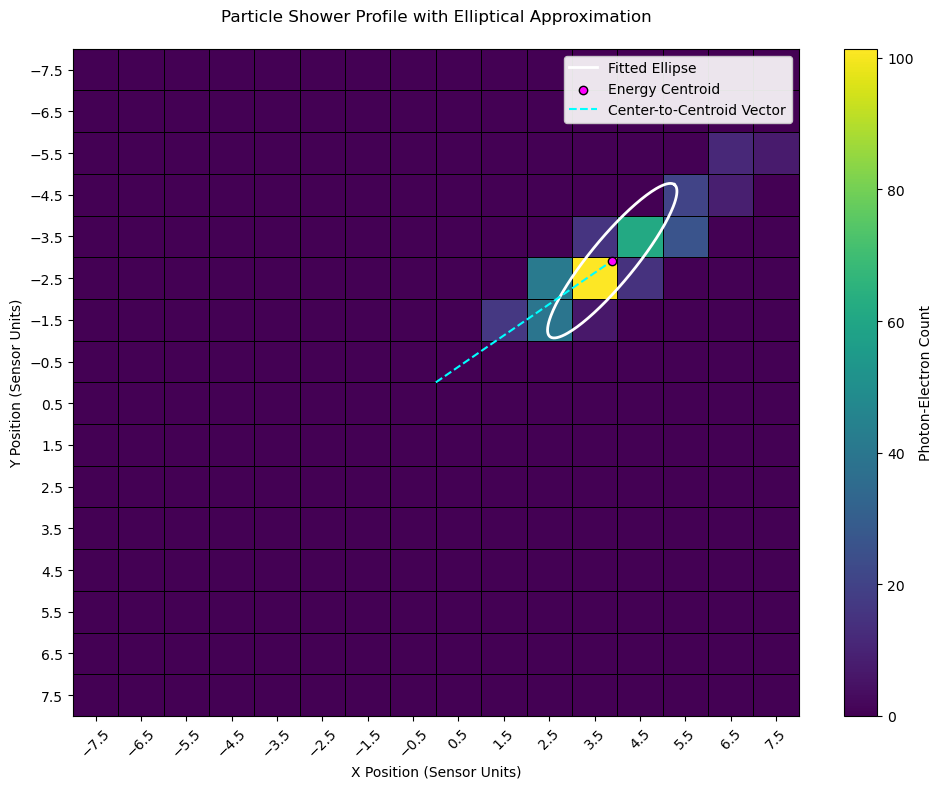

centroid_position: (np.float64(3.8904427923286775), np.float64(-2.918233199475969))
longitudinal_extension: 1.6305
transverse_extension: 0.3633
orientation_angle_degrees: 126.7970
elliptical_eccentricity: 0.9749
edge_leakage_ratio: 0.0199
axis_miss_distance: 0.0065
azimuthal_spread: 0.5759
distribution_asymmetry: 0.4941
radial_displacement: 4.8633
radial_orientation_angle: 16.3293


In [32]:


from dataclasses import asdict

result = analyze_shower(step2_pixels, generate_visualization=True)


for key, value in asdict(result).items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")



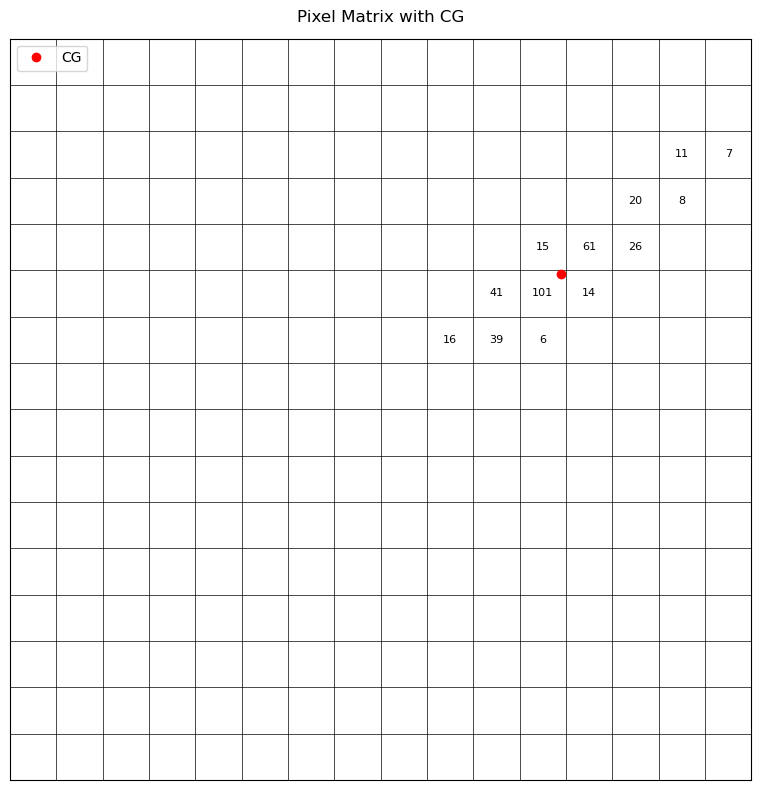

Center of Gravity (x_cg, y_cg): (11.39, 4.58)


In [35]:
plot_pixel_matrix_with_cg(step2_pixels, "Pixel Matrix with CG")